In [ ]:
#default_exp 1d_waveform

# Training Overview

Same as the 1D case, the goal here is to learn a low-dimensional function which encodes the waveform (amplitude) of the surf.

We have the following to work with:
1. A normalized greyscale video tensor of shape `(y_img, x_img, t)` (image coordinates over time)
1. An incomplete supervisory signal tensor which correlates to high-amplitude (the foam wavefronts of broken waves) of shape `(y,x,t)`

The eventual goal here is to learn a mapping from `greyscale_video_tensor` to a function `amplitude(x_ocean,y_ocean,t)` in a flat euclidean plain corresponding to the ocean's surface, which respects various known physical constraints on the waveform. Learning this waveform will give us the ability to train better wave detection models and infer more information about the surfbreak such as bathometry (shape of the ocean floor).

## Basic waveform fitting in 2D
With the basics of 1D fitting working (see `06_learn_1d_waveform.ipynb`) we want to expand this to 2 spatial dimensions and one 1 dimension. 

In this simplified setting, the amplitude function would look like $amplitude = f(y, x, t)$

The general steps to follow (using only a vertical slice of the input video) are:
1. Test the concept initially by directly regressing `f(y_img,x_img,t)` on the encoded supervisory signal. 
1. Apply some physics constraints as used in the SIREN paper (see https://github.com/vsitzmann/siren/blob/master/loss_functions.py#L112) 
1. Apply some domain knowledge (see `01_wave_modeling.ipynb`) to regularize the regressed waveform.
1. Learn to regress from the normalized video itself, using the supervisory signal only as a piece of the loss function (instead of as input).


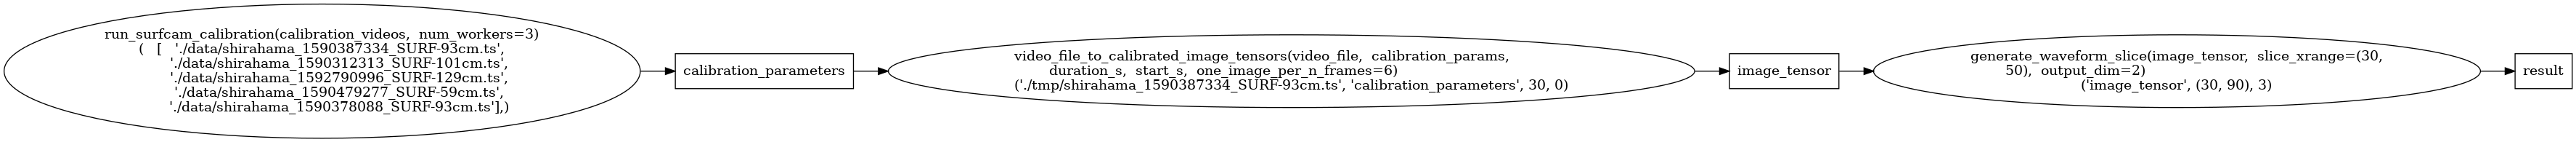

In [ ]:
%load_ext autoreload
%autoreload 2
from surfbreak import graphutils, supervision
import pipelines
import graphchain
import dask
import matplotlib.pyplot as plt

show_image = supervision.show_image

# TODO: Improve this pipeline to chunk the image_tensor (memory usage...). 

# These tensors are 10hz by default (1/6th of the frames from a of 60Hz video)
waveform_slice_graph = pipelines.video_to_waveform_slice('./tmp/shirahama_1590387334_SURF-93cm.ts',
                                                         duration_s=30, start_s=0,
                                                         slice_xrange=(30,90), output_dim=3)

graphutils.visualize(waveform_slice_graph)

### Define the inputs

(145, 60, 297)


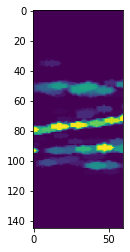

In [ ]:
wavefront_tensor = graphchain.get(waveform_slice_graph, "result")
print(wavefront_tensor.shape)
plt.imshow(wavefront_tensor[:,:,50])
#supervision.animate_tensor(wavefront_tensor[:,:,::5], colorbar=False)

## Next Steps
1. Get the basic SIREN 2d image fitting model working from https://vsitzmann.github.io/siren/
1. Figure out how to imbue this model with physics constraints in the (y,time) dimensions

In [ ]:
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
from PIL import Image
import explore_siren as siren

def normalize_tensor(tensor, clip_max=1):
    return ((tensor - tensor.mean()) / tensor.std()).clip(max=clip_max)

def get_wavefront_tensor(ydim_out, tdim_out, slice_xrange=(30,90), output_dim=3):
    waveform_slice_graph = pipelines.video_to_waveform_slice('./tmp/shirahama_1590387334_SURF-93cm.ts',
                                                                duration_s=30, start_s=0,
                                                                slice_xrange=slice_xrange, output_dim=output_dim)
    waveform_array = graphchain.get(waveform_slice_graph, "result")
    # Incredibly important to clip the large peak values in this raw waveform_array
    waveform_tensor = torch.from_numpy(normalize_tensor(waveform_array, clip_max=1.))
    ydim_in, xdim_in, tdim_in = waveform_tensor.shape 
    xdim_out = int(ydim_out * (xdim_in / ydim_in))
    # [None, None,...] nonsense below is adding and removing [batch, channel] dimensions required by F.interpolate
    resized_tensor = F.interpolate(waveform_tensor[None,None,...], size=(ydim_out, xdim_out, tdim_out),
                                   mode='trilinear', align_corners=False)
    return resized_tensor[0,0,...]

def get_mgrid(sidelen_tuple):
    '''Generates a flattened grid of (y,x,t,...) coordinates in a range of -1 to 1.
    sidelen_tuple: tuple of coordinate side lengths (y,x,t)
    '''
    tensors = tuple([torch.linspace(-1, 1, steps=sidelen) for sidelen in sidelen_tuple])
    mgrid = torch.stack(torch.meshgrid(*tensors), dim=-1)
    mgrid = mgrid.reshape(-1, len(sidelen_tuple))
    return mgrid

class WaveformFitting2D(Dataset):
    def __init__(self, ydim_out, tdim_out, slice_xrange=(30,90)):
        super().__init__()
        yxt_tensor = get_wavefront_tensor(ydim_out, tdim_out, slice_xrange=slice_xrange)
        self.gt_pixels = yxt_tensor.view(-1, 1)
        sidelen_tuple = yxt_tensor.shape
        self.coords = get_mgrid(sidelen_tuple)
        self.tensor_shape = yxt_tensor.shape
        
        self.yx_slice_tval = 50
        self.yx_slice_gt = self.gt_pixels.view(-1, *self.tensor_shape)[:,:,:,self.yx_slice_tval]
        self.yx_slice_coords = self.coords.view(-1, *self.tensor_shape, 3)[:,:,:,self.yx_slice_tval]

        self.yt_slice_xval = self.tensor_shape[1]//2 
        self.yt_slice_gt = self.gt_pixels.view(-1, *self.tensor_shape)[:,:,self.yt_slice_xval, :]
        self.yt_slice_coords = self.coords.view(-1, *self.tensor_shape, 3)[:,:,self.yt_slice_xval, :]

    def __len__(self):
        return 1

    def __getitem__(self, idx):    
        if idx > 0: raise IndexError

        return self.coords, self.gt_pixels
    

In [ ]:
import torch
import math

def subsample_strided_buckets(flat_batch, yxt_dims, bucket_sidelength, samples_per_bucket=100,
                              return_xy_buckets=False, sample_offset=0):
    """Samples channel values form yxt tensors along bucketed spatial (x,y) dimensions.
       Leaves the time dimension the same. Return a tensor of dimensions (time, channel, buckets, samples)
       Input:  tensor (batch, flat_elements, channels)
       Output: tensor (bucket, samples, time, channels) 
               OR (y,x,s,t,c) if return_xy_buckets=True
       
       Only samples from the first element in the batch
       if return_xy_buckets=True, buckets are indexed by x and ycoordinates"""
    n_channels = flat_batch.shape[-1]
    #print("fb: ", flat_batch.shape)
    byxtc_input = flat_batch.reshape(-1, *yxt_dims, n_channels)
    #print("byxtc: ", byxtc_input.shape)
    tcyx_input = byxtc_input.permute(0,3,4,1,2)[0] # first element in batch only
    #print("tcyx: ", tcyx_input.shape)
    
    stride = bucket_sidelength
    # Fold: Expands a rolling window of kernel_size, with overlap between windows if stride < kernel_size
    #       input tensor of shape (N,C,T) , where N is the batch dimension, C is the channel dimension, 
    #       and * represent arbitrary spatial dimensions
    #          See https://pytorch.org/docs/master/generated/torch.nn.Unfold.html#torch.nn.Unfold
    ufx = F.unfold(tcyx_input,kernel_size=bucket_sidelength, stride=stride)
    #print("ufx:", ufx.shape)
    n_buckets = ufx.shape[-1]
    tcsb = ufx.reshape(yxt_dims[2], n_channels,-1,n_buckets)
    #print("tcsb:", tcsb.shape)
    n_total_samples = tcsb.shape[2]
    subsample_stride = n_total_samples//samples_per_bucket
    offset_idx = sample_offset%subsample_stride
    tcsb_sampled = tcsb[...,:offset_idx + samples_per_bucket*subsample_stride:subsample_stride,:]
    #print("Trying b -> x,y: ", tcsb_sampled.shape[-1], yxt_dims[0]//stride, yxt_dims[1]//stride)
    #print("tcsb_samp: ", tcsb_sampled.shape)
    if return_xy_buckets:
        tcsyx = tcsb_sampled.reshape(tcsb_sampled.shape[0], tcsb_sampled.shape[1], tcsb_sampled.shape[2], 
                                 yxt_dims[0]//stride, yxt_dims[1]//stride)
        return tcsyx.permute(3,4,2,0,1)
    else:
        return tcsb_sampled.permute(3,2,0,1)

class BucketedWaveformFitting2D(Dataset):
    def __init__(self, ydim_out, tdim_out, slice_xrange=(30,90), bucket_sidelen=20, samples_per_bucket=20, time_sampling_interval=5,
                 coord_order='txy'):
        super().__init__()
        yxt_tensor = get_wavefront_tensor(ydim_out, tdim_out, slice_xrange=slice_xrange)
        self.gt_pixels = yxt_tensor.view(-1, 1)
        sidelen_tuple = yxt_tensor.shape
        self.coords = get_mgrid(sidelen_tuple)
        self.tensor_shape = yxt_tensor.shape
        self.coord_order=coord_order
        
        self.bucket_sidelen = 20
        self.samples_per_bucket = samples_per_bucket
        self.time_sampling_interval = time_sampling_interval

        self.yx_slice_tval = 50
        self.yx_slice_gt = self.gt_pixels.view(-1, *self.tensor_shape)[:,:,:,self.yx_slice_tval]
        self.yx_slice_coords = self.coords.view(-1, *self.tensor_shape, 3)[:,:,:,self.yx_slice_tval]

        self.yt_slice_xval = self.tensor_shape[1]//2 
        self.yt_slice_gt = self.gt_pixels.view(-1, *self.tensor_shape)[:,:,self.yt_slice_xval, :]
        self.yt_slice_coords = self.coords.view(-1, *self.tensor_shape, 3)[:,:,self.yt_slice_xval, :]

    def __len__(self):
        return 1

    def __getitem__(self, idx):                    
        bstc_ground_truth = subsample_strided_buckets(self.gt_pixels, self.tensor_shape, 
                                                      bucket_sidelength=self.bucket_sidelen, samples_per_bucket=self.samples_per_bucket,
                                                      sample_offset=idx)
        bstc_input_coords = subsample_strided_buckets(self.coords, self.tensor_shape, 
                                                      bucket_sidelength=self.bucket_sidelen, samples_per_bucket=self.samples_per_bucket,
                                                      sample_offset=idx)

        # Also sample over time dimension, every 10th offset each epoch
        bti = self.time_sampling_interval
        ground_truth_pixels = bstc_ground_truth[:,:,idx%bti::bti,:].reshape(bstc_ground_truth.shape[0], -1, 
                                                                        bstc_ground_truth.shape[-1])
        model_input_coords = bstc_input_coords[:,:,idx%bti::bti,:].reshape(bstc_input_coords.shape[0], -1, 
                                                                       bstc_input_coords.shape[-1])
        
        if self.coord_order is 'txy':
            model_input_coords = torch.stack((model_input_coords[...,2], 
                                              model_input_coords[...,1], 
                                              model_input_coords[...,0]), dim=2)
        elif self.coord_order is 'yxt':
            pass
        else:
            raise RuntimeError("Undefined coord_order")
        

        return model_input_coords, ground_truth_pixels

torch.Size([128, 52, 150])
windows: torch.Size([8, 3, 100, 150, 1])


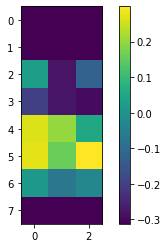

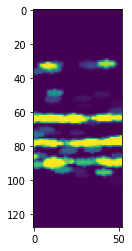

In [ ]:
waveform = WaveformFitting2D(ydim_out=128, tdim_out=150)
dataloader = DataLoader(waveform, batch_size=1, pin_memory=True, num_workers=0)
model_input, ground_truth = next(iter(dataloader))
print(waveform.tensor_shape)
yxstc_buckets = subsample_strided_buckets(ground_truth, waveform.tensor_shape, 
                                          bucket_sidelength=15, return_xy_buckets=True)
print("windows:", yxstc_buckets.shape)
avg_sample_intensity = yxstc_buckets.mean(dim=2)[:,:,40,0]
plt.imshow(avg_sample_intensity)
plt.colorbar()
plt.show()
plt.imshow(ground_truth.reshape(waveform.tensor_shape)[:,:,40])

torch.Size([128, 52, 150])
windows: torch.Size([12, 5, 100, 150, 3])


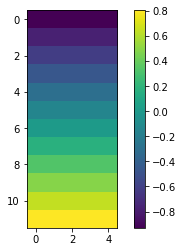

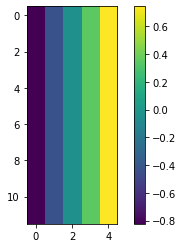

In [ ]:
waveform = WaveformFitting2D(ydim_out=128, tdim_out=150)
dataloader = DataLoader(waveform, batch_size=1, pin_memory=True, num_workers=0)
model_input, ground_truth = next(iter(dataloader))
print(waveform.tensor_shape)
yxstc_buckets = subsample_strided_buckets(model_input, waveform.tensor_shape, 
                                          bucket_sidelength=10, return_xy_buckets=True)
print("windows:", yxstc_buckets.shape)
avg_sample_intensity = yxstc_buckets.mean(dim=2)[:,:,40,0]
plt.imshow(avg_sample_intensity)
plt.colorbar()
plt.show()
plt.imshow(yxstc_buckets.mean(dim=2)[:,:,40,1])
plt.colorbar()


In [ ]:
waveform = WaveformFitting2D(ydim_out=128, tdim_out=150)
dataloader = DataLoader(waveform, batch_size=1, pin_memory=True, num_workers=0)
model_input, ground_truth = next(iter(dataloader))
print(ground_truth.shape)

torch.Size([1, 998400, 1])


In [ ]:
waveform = BucketedWaveformFitting2D(ydim_out=128, tdim_out=150)
dataloader = DataLoader(waveform, batch_size=1, pin_memory=True, num_workers=0)
model_input, ground_truth = next(iter(dataloader))
print(ground_truth.shape)

torch.Size([1, 12, 600, 1])


### Define cost function which only penalizes missing peaks

#### Also conserve change in amplitude between Y-dimension buckets over time

First, approximate to ideal 1-dimensional problem in time. We know waves move with monotonic, decreasing velocity. 
For now *assume constant wave speed* in vertical pixel space (the perspective of the image counteracts the actual decreasing speed)
Have this wave speed (dy/dt) be a learnable parameter - inially fixed, later varying smoothly as a function of y. 

Amplitude in a cell at one timestep should either:
1. Remain in that cell until the next timestep (cell to the right)
1. Move to the next cell on the next timestep (cell to the bottom-right)
1. Enter from the cell above in the previous timestep (upper-left)

Steps to calculate cost function:
1. Find delta-amplitude in time of cell above
1. Find delta-amplitude in time of cell
1. Find delta-amplitude in time of cell below
1. Sum of the above three should be ~ zero if cells are larger than the amplitude peaks

This will result in large costs for horizontal (stationary amplitude), and vertical (

### Training loop

In [ ]:
from surfbreak.loss_functions import wave_pml 

def fit_waveform_slice(lr=1e-4,first_omega_0=1, lossfunc='mse', total_steps=401, steps_til_summary=100,
                       slice_xrange=(30,90), squared_slowness=3, wave_loss_scale=1e-7, samples_per_bucket=20):
    tensor_ydim=128
    tensor_tdim=150
    single_waveform_dataset = BucketedWaveformFitting2D(tensor_ydim, tensor_tdim, slice_xrange=slice_xrange, coord_order='txy',
                                                        samples_per_bucket=samples_per_bucket)
    dataloader = DataLoader(single_waveform_dataset, batch_size=1, pin_memory=True, num_workers=0)

    tensor_xdim = single_waveform_dataset.tensor_shape[1]
    waveform_tensor_shape = tensor_ydim, tensor_xdim, tensor_tdim
    print("Scaled waveform tensor shape (t, x, y): ", waveform_tensor_shape)

    img_siren = siren.Siren(in_features=3, out_features=1, hidden_features=128, 
                    hidden_layers=3, outermost_linear=True, first_omega_0=1, dydt=0.65)
    img_siren.cuda()

    """We now fit Siren in a simple training loop. Within only hundreds of iterations, the image and its gradients are approximated well."""

    total_steps = total_steps # Since the whole image is our dataset, this just means 500 gradient descent steps.
    n_plots = total_steps//steps_til_summary + 2
    fig, axes = plt.subplots(2, n_plots, figsize=(3*n_plots+1,3*2), sharex=False, sharey=True)
    plt.tight_layout

    optim = torch.optim.Adam(lr=lr, params=img_siren.parameters())
        
    for step in range(total_steps):    
        
        model_input, ground_truth =  next(iter(dataloader)) # Each step gives a subsampled, bucketed set of coordinates
        model_input = model_input.reshape(*model_input.shape[1:])  # The batch dimension is the buckets, so removing empty default batch dimension
        ground_truth = ground_truth.reshape(*ground_truth.shape[1:])
        
        # Actually run the data through the model
        model_input, ground_truth = model_input.cuda(), ground_truth.cuda()
        model_output, coords = img_siren(model_input)
        
        if lossfunc is 'mse':
            mse_loss = ((model_output - ground_truth)**2).mean()
            
            if squared_slowness is None:
                wavefunc_loss = 0
            else:
                # TODO: Make squared slowness a learned parameter - better, a function!
                # (eventally, use this to infer ocean depth from wavespeed)
                squared_slowness_tensor = torch.ones_like(coords) * squared_slowness
                wave_loss_dict = wave_pml({'model_in': coords, "model_out": model_output}, 
                                          gt={'squared_slowness':squared_slowness_tensor})

                wavefunc_loss = wave_loss_dict['diff_constraint_hom']*wave_loss_scale # * min(1, (step/ total_steps)**2)
                
            loss = mse_loss + wavefunc_loss
            
        elif lossfunc is 'grad':
            # Push average amplitude to 0 for all groups of 40pix x 0.4s (20x20 from y,t input coodinates)
            #yt_buckets = image_to_strided_buckets(model_output, image_dim=img_dim, pix_per_bucket=30)
            #amplitude_window_loss = (yt_buckets.reshape(model_output.shape[0],-1)**2).sum()
                        
            # Sum of the average of spatially-batched samples (REQUIRES batches to be spatially sampled)
            # L2 norm of values over the time*samples dimension, then mean over spatial batch dimensions
            #avg_bucket_loss = ((model_output.mean(dim=1))**2).mean()
            #avg_bucket_loss = 0
            
            # Penalize values for being low, when the supervision mask (correlated to wavefronts) is high
            #foam_wavefront_mask = ground_truth > (ground_truth.mean() + ground_truth.std())
            #loss_mask = (((model_output - 1).clamp(min=-10, max=0)**2)*foam_wavefront_mask).mean()*100
            loss_mse = ((model_output - ground_truth)**2).mean()
            
            # Low amplitude gradients (and higher-order laplace = gradient's gradient)
            grad_loss    =  siren.gradient(model_output, coords).abs().mean()*0.001
            laplace_loss =  siren.laplace(model_output, coords).abs().mean()*0.0001
            loss = loss_mse + grad_loss + laplace_loss

        if not step % steps_til_summary:
            if lossfunc is 'mse':
                print("Step %d, Total loss %0.6f" % (step, loss), "  wavefunc: %0.6f" % wavefunc_loss)
            else:
                print("Step %d, Total loss %0.6f" % (step, loss), " mse:{:.6f}, grad:{:.6f}, laplace:{:.6f}"
                      .format(loss_mse, grad_loss, laplace_loss))
                
            img_grad = siren.gradient(model_output, coords)
            img_laplacian = siren.laplace(model_output, coords)
            
            
            #print("xy_slice:", single_waveform_dataset.yx_slice_coords.shape)
            #ty_slice_coords = tensingle_waveform_dataset.yx_slice_coords[...,0]
            
            yx_model_output, yx_coords = img_siren(single_waveform_dataset.yx_slice_coords[-1,:,:,None].cuda().view(1, -1, 3))
            yt_model_output, yt_coords = img_siren(single_waveform_dataset.yt_slice_coords[-1,:,None,:].cuda().view(1, -1, 3))
            
            
            yx_gt_img = single_waveform_dataset.yx_slice_gt[0].cpu().squeeze()
            yx_model_img = yx_model_output.detach().cpu().squeeze().view(tensor_ydim, tensor_xdim)
            
            yt_gt_img = single_waveform_dataset.yt_slice_gt[0].cpu().squeeze()
            yt_model_img = yt_model_output.detach().cpu().squeeze().view(tensor_ydim, tensor_tdim)
            
            if False:
                print("coords : yx: ",yx_slice_coords.shape, "  yt:", yt_slice_coords.shape)
                print("output: yx: ",yx_model_output.shape, "  yt:", yt_model_output.shape)
                print("img:  yx: ", yx_gt_img.shape, "  yt: ", yt_gt_img.shape)

            
            if step==0:
                axes[0][0].set_title("yx ground truth " + "({:.2f},{:.2f})".format(yx_gt_img.min(), yx_gt_img.max()))
                axes[0][0].imshow(yx_gt_img)
                axes[1][0].set_title("yt ground truth " + "({:.2f},{:.2f})".format(yx_gt_img.min(), yx_gt_img.max()))
                axes[1][0].imshow(yt_gt_img)

            axes[0][step//steps_til_summary+1].set_title("Model yx "+str(step) + " ({:.2f},{:.2f})"
                                                       .format(yx_model_img.min(), yx_model_img.max()))
            axes[0][step//steps_til_summary+1].imshow(yx_model_img)

            axes[1][step//steps_til_summary+1].set_title("Model yt "+str(step) + " ({:.2f},{:.2f})"
                                                       .format(yt_model_img.min(), yt_model_img.max()))
            axes[1][step//steps_til_summary+1].imshow(yt_model_img)

            #img_grad = img_grad.norm(dim=-1).cpu().view(img_dim,img_dim).detach().numpy()
            #axes[2][step//steps_til_summary].set_title("Grad: ({:.2f},{:.2f})".format(img_grad.min(), img_grad.max()))
            #axes[2][step//steps_til_summary].imshow(img_grad)
            #axes[2][step//steps_til_summary].imshow(img_laplacian.cpu().view(img_dim,img_dim).detach().numpy())

        optim.zero_grad()
        loss.backward()
        optim.step()
    plt.show()
    return img_siren.cpu()

Scaled waveform tensor shape (t, x, y):  (128, 52, 150)
Step 0, Total loss 0.183726   wavefunc: 0.000000
Step 100, Total loss 0.099351   wavefunc: 0.000000
Step 200, Total loss 0.042822   wavefunc: 0.000000
Step 300, Total loss 0.023274   wavefunc: 0.000000
Step 400, Total loss 0.011067   wavefunc: 0.000000


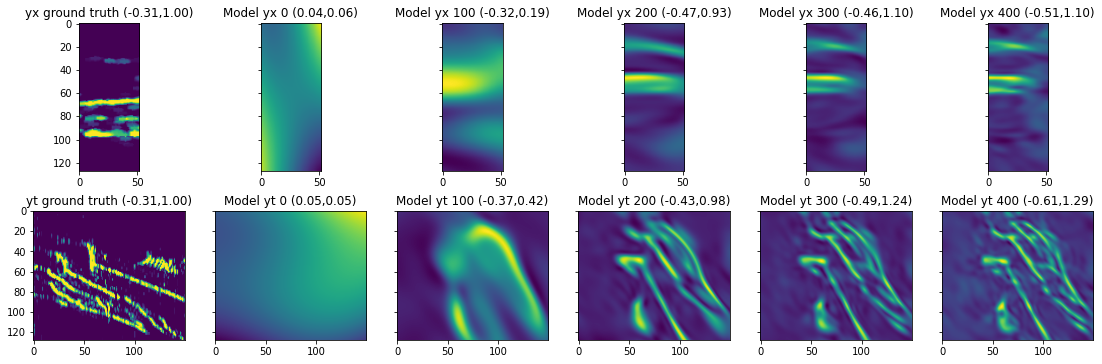

In [ ]:
# Fit without any wavefunction normalization
siren_model = fit_waveform_slice(lr=1e-4, first_omega_0=1, total_steps=201, steps_til_summary=100, squared_slowness=None)

Scaled waveform tensor shape (t, x, y):  (128, 52, 150)
Step 0, Total loss 0.174443   wavefunc: 0.000004
Step 100, Total loss 0.103534   wavefunc: 0.003716
Step 200, Total loss 0.080895   wavefunc: 0.012439
Step 300, Total loss 0.075957   wavefunc: 0.015798
Step 400, Total loss 0.074058   wavefunc: 0.016987
Step 500, Total loss 0.073262   wavefunc: 0.017707


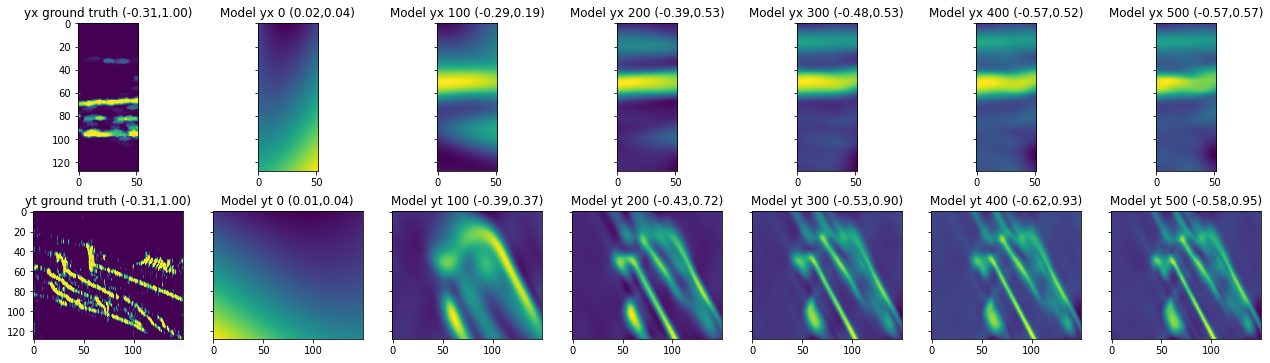

In [ ]:
# Fit with a fixed squared slowness (wave speed) in image space
siren_model = fit_waveform_slice(lr=1e-4, first_omega_0=1, total_steps=501, steps_til_summary=100, squared_slowness=5, wave_loss_scale=1e-7)

#### Squared slowness of around 3-4 seems to be most accurate, as measured by eye on various plots

Scaled waveform tensor shape (t, x, y):  (128, 132, 150)
Step 0, Total loss 0.189054   wavefunc: 0.000011
Step 100, Total loss 0.106988   wavefunc: 0.001651
Step 200, Total loss 0.078275   wavefunc: 0.009101
Step 300, Total loss 0.070547   wavefunc: 0.012101
Step 400, Total loss 0.067116   wavefunc: 0.013033


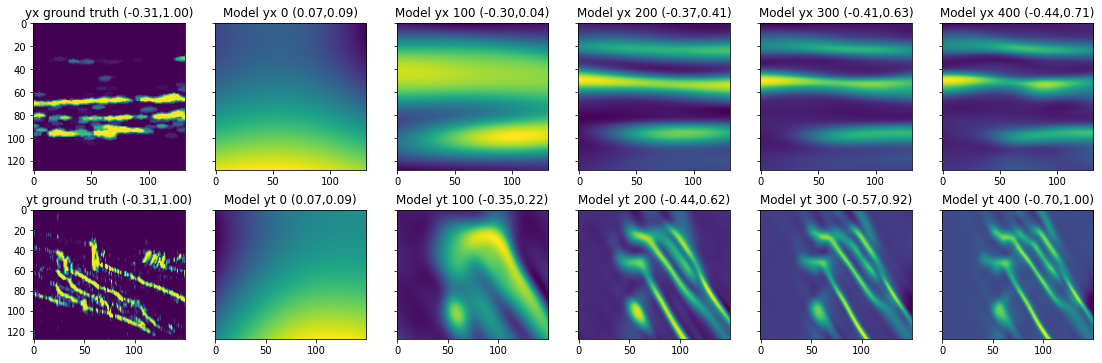

In [ ]:
siren_model = fit_waveform_slice(lr=1e-4, lossfunc='mse', first_omega_0=1, total_steps=401, steps_til_summary=100,
                                 slice_xrange=(20,170), squared_slowness=3, wave_loss_scale=2e-8, samples_per_bucket=15)
torch.cuda.empty_cache()

Scaled waveform tensor shape (t, x, y):  (128, 132, 150)
Step 0, Total loss 0.150448   wavefunc: 0.000012
Step 100, Total loss 0.109363   wavefunc: 0.003674
Step 200, Total loss 0.097825   wavefunc: 0.009910
Step 300, Total loss 0.094547   wavefunc: 0.012598
Step 400, Total loss 0.093442   wavefunc: 0.013481


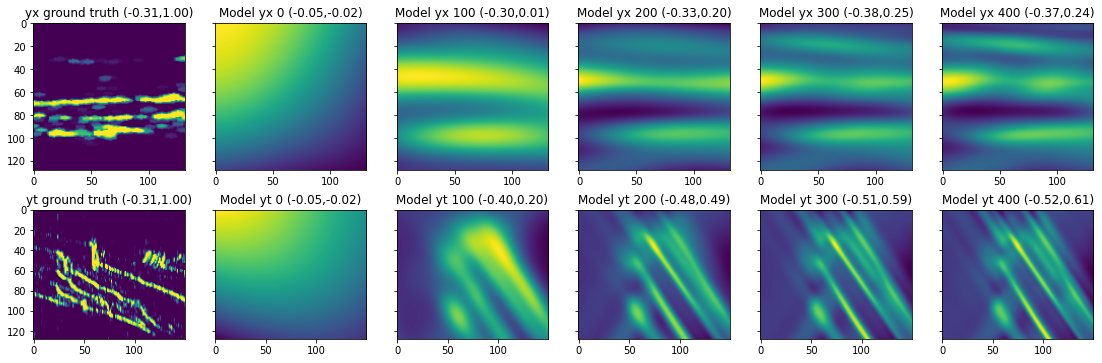

In [ ]:
siren_model = fit_waveform_slice(lr=1e-4, lossfunc='mse', first_omega_0=1, total_steps=401, steps_til_summary=100,
                                 slice_xrange=(20,170), squared_slowness=3, wave_loss_scale=1e-7, samples_per_bucket=15)
torch.cuda.empty_cache()

Scaled waveform tensor shape (t, x, y):  (128, 132, 150)
Step 0, Total loss 0.155835   wavefunc: 0.000165
Step 100, Total loss 0.117484   wavefunc: 0.000926
Step 200, Total loss 0.114685   wavefunc: 0.002673
Step 300, Total loss 0.111321   wavefunc: 0.006471
Step 400, Total loss 0.109597   wavefunc: 0.006401


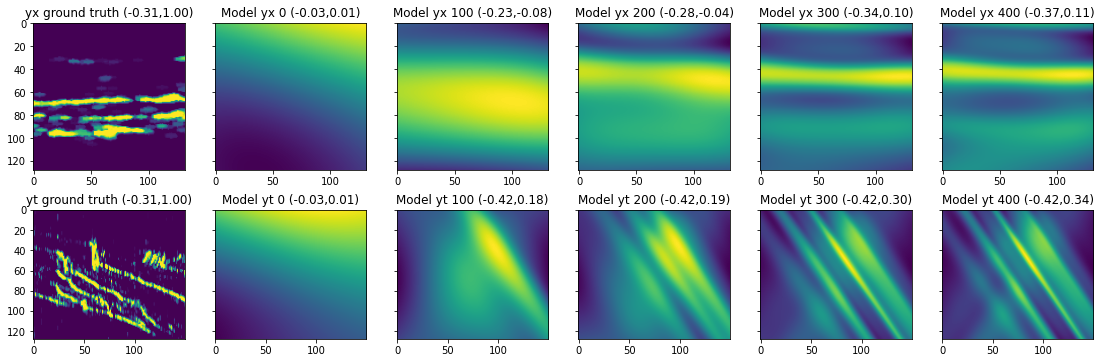

In [ ]:
siren_model = fit_waveform_slice(lr=1e-4, lossfunc='mse', first_omega_0=1, total_steps=401, steps_til_summary=100,
                                 slice_xrange=(20,170), squared_slowness=3, wave_loss_scale=4e-7, samples_per_bucket=15)
torch.cuda.empty_cache()

torch.Size([128, 88, 150])
(128, 88, 150)


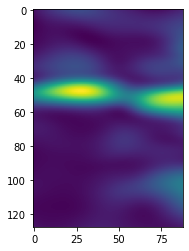

In [ ]:
tensor_ydim=128
tensor_tdim=150
eval_model = siren_model.eval().cpu()

waveform_dataset = WaveformFitting2D(tensor_ydim, tensor_tdim, slice_xrange=(20,120), )
print(waveform_dataset.tensor_shape)
model_input, ground_truth = next(iter(waveform_dataset))
# Calculate and reshape the actual output tensor
model_output, coords  = eval_model(model_input.cpu())
output_tensor = model_output.view(-1, *waveform_dataset.tensor_shape)[0].detach().numpy()
# View the output
print(output_tensor.shape)
plt.imshow(output_tensor[:,:,40])

In [ ]:
#supervision.animate_tensor(output_tensor, colorbar=True)

In [ ]:
#supervision.animate_tensor(ground_truth.reshape(output_tensor.shape), colorbar=True)